https://www.kaggle.com/code/rajmehra03/cf-based-recsys-by-low-rank-matrix-factorization

In [1]:
import os
# Comprueba si el código se está ejecutando en Google Colab
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

path_absolute = ''
if IN_COLAB:
    print("El código se está ejecutando en Google Colab.")
    from google.colab import drive

    drive.mount('/content/drive')
    path_absolute = '/content/drive/Othercomputers/Mi_portátil/TFM/WorkSpace/'

    # Cambia al directorio de tu carpeta en Google Drive
    os.chdir(path_absolute)

    # Lista los archivos y carpetas en el directorio actual
    contenido_carpeta = os.listdir(path_absolute)
    print("Contenido de la carpeta en Google Drive:")
    print(contenido_carpeta)
else:
    print("El código se está ejecutando en un entorno local.")
    path_absolute = os.getcwd().replace("\\", "/")

datasets_path = "/datasets"
path_absolute = path_absolute+datasets_path

El código se está ejecutando en un entorno local.


## Collaborative Filtering Based Recommender Systems using Low Rank Matrix Factorization(User & Movie Embeddings) & Neural Network in Keras.

## [ Please star/upvote in case you like it. ]

## CONTENTS::->

[ **1 ) Exploratory the Data**](#content1)

[ **2 ) Preparing the Data**](#content2)

[ **3 ) Matrix Factorization**](#content3)

[ **4 ) Evaluating the Model Performance**](#content4)

[ **5 ) Using a Neural Network**](#content5)

<a id="content1"></a>
## 1 ) Exploring the Data

## 1.1 ) Importing Various Modules

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , concatenate
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


# from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image


#TL pecific modules
from keras.applications.vgg16 import VGG16

## 1.2 ) Reading the CSV file

In [3]:
# train=pd.read_csv(path_absolute+'/ratings.csv')

In [4]:
ratings = pd.read_csv(path_absolute+'/df_mezclado_tags_ratings_movies_links_genTags.csv')
print(ratings.shape)
df_ratings_merge = ratings.copy()
df_ratings_merge = df_ratings_merge.sample(n=70000, random_state=42)
# Inserta la columna 'rating' en la última posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-1, 'rating', df_ratings_merge.pop('rating'))
# Inserta la columna 'relevance' en la penúltima posición del DataFrame
df_ratings_merge.insert(len(df_ratings_merge.columns)-2, 'relevance', df_ratings_merge.pop('relevance'))
# Inserta la columna 'tag_etiquetas_genómicas' despues de tag_df_mezclado
df_ratings_merge.insert(5, 'tag_etiquetas_genómicas', df_ratings_merge.pop('tag_etiquetas_genómicas'))

# Renombrar algunas columnas:
df_ratings_merge.rename(columns={'timestamp_valoraciones': 'timestamp_rt', 'timestamp_etiquetas': 'timestamp_tags', 'tag_df_mezclado_tags_ratings_movies_links_genMov': 'tag_by_user', 'tag_etiquetas_genómicas': 'gen_tag'}, inplace=True)

# Elimino las columnas: 
columnas_a_eliminar = ['imdbId', 'tmdbId']
df_ratings_merge = df_ratings_merge.drop(columnas_a_eliminar, axis=1)
print(df_ratings_merge.shape)
df_ratings_merge.head()

(8949372, 13)
(70000, 11)


,userId,movieId,timestamp_rt,tag_by_user,timestamp_tags,gen_tag,title,genres,tagId,relevance,rating
1561133,60101,2571,1053445162,dystopia,1244667471,hitman,"Matrix, The (1999)",Action|Sci-Fi|Thriller,512,0.12625,5.0
1499330,42923,1228,1330057917,classic,1330057913,nocturnal,Raging Bull (1980),Drama,710,0.60700,4.0
1048680,7620,34532,1144937579,Magick,1144937622,true story,"Skeleton Key, The (2005)",Drama|Horror|Mystery|Thriller,1047,0.05750,5.0
1703441,62199,5636,1199318408,Anthony Russo,1328741490,adoption,Welcome to Collinwood (2002),Comedy|Crime,27,0.05325,3.0
5648649,29801,6250,1476349149,Stephen King,1476349186,cult film,Dreamcatcher (2003),Drama|Horror|Sci-Fi|Thriller,276,0.36500,2.0


In [5]:
train = df_ratings_merge.copy()

I am using the movie-lens-100K data. Note that this file contains the ratings given by our set of users to different movies. In all it contains total 100K ratings; to be exact 1000004.

In [6]:
df=train.copy()

In [7]:
# df.head()

## 1.3 ) Exploring the dataset

In [8]:
df['userId'].unique()

array([ 60101,  42923,   7620, ...,  62638, 120154,   9015], dtype=int64)

In [9]:
len(df['userId'].unique())

6136

Note that in total we have 671 unique users whose userid range from 1->671.

In [10]:
df['movieId'].unique()

array([  2571,   1228,  34532, ...,  86244,  34530, 171439], dtype=int64)

In [11]:
len(df['movieId'].unique())

7821

Similarly we have 9066 unique movies, Also note that as provided each user has voted for atleast 20 movies. We will see that the utility matrix thus created thus is quite sparse.

<small>#### Note that for 671 users and 9066 movies we can have a maximum of 671*9066 = 6083286 ratings. But note that we have only 100004 ratings with us. Hence the utility matrix has only about 1.6 % of the total values. Thus it can be concluded that it is quite sparse. This limits the use of some algorithms. Hence we will create embeddings for them later.</small>

#### Observe que para 671 usuarios y 9066 películas podemos tener un máximo de 671*9066 = 6083286 valoraciones. Pero ten en cuenta que sólo tenemos 100004 valoraciones. Por lo tanto, la matriz de utilidad sólo tiene alrededor del 1,6% de los valores totales. Por lo tanto, se puede concluir que es bastante dispersa. Esto limita el uso de algunos algoritmos. Por lo tanto, crearemos incrustaciones para ellos más adelante.

In [12]:
df['userId'].isnull().sum()

0

In [13]:
df['rating'].isnull().sum()

0

In [14]:
df['movieId'].isnull().sum()

0

This confirms that none of the columns has any NULL or Nan value.

In [15]:
df['rating'].min() # minimum rating

0.5

In [16]:
df['rating'].max() # maximum rating

5.0

<a id="content2"></a>
## 2 ) Preparing the data

## 2.1 ) Encoding the columns

In [17]:
# Convierten las columnas userId y movieId de un DataFrame df en variables categóricas y 
# asignan códigos numéricos a esas categorías.
df.userId = df.userId.astype('category').cat.codes.values
df.movieId = df.movieId.astype('category').cat.codes.values

In [18]:
df['userId'].value_counts(ascending=True)

194        1
3976       1
5495       1
5663       1
116        1
        ... 
577      729
4988     796
6072     993
5897    1000
252     1811
Name: userId, Length: 6136, dtype: int64

In [19]:
df['movieId'].unique()

array([1273,  593, 4142, ..., 5752, 4141, 7403], dtype=int16)

## 2.2 ) Creating the Utility Matrix

In [20]:
# creating utility matrix.
index=list(df['userId'].unique())
columns=list(df['movieId'].unique())
index=sorted(index)
columns=sorted(columns)
 
util_df=pd.pivot_table(data=df,values='rating',index='userId',columns='movieId')
# Nan implies that user has not rated the corressponding movie.

In [21]:
util_df

movieId,0,1,2,3,4,5,6,7,8,9,...,7811,7812,7813,7814,7815,7816,7817,7818,7819,7820
userId,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### BREAKING IT DOWN--

<small> 

1) This is the utility matrix; for each of the 671 users arranged rowwise; each column shows the rating of the movie given by a particular user.

2) Note that majority of the matrix is filled with 'Nan' which shows that majority of the movies are unrated by many users.

3) For each movie-user pair if the entry is NOT 'Nan' the vaue indicates the rating given by user to that corressponding movie. 

4) For now I am gonna fill the 'Nan' value with value '0'. But note that this just is just indicative, a 0 implies NO RATING and doesn't mean that user has rated 0 to that movie. It doesn't at all represent any rating.</small>

1) Esta es la matriz de utilidad de cada uno de los 671 usuarios, ordenada por filas; cada columna muestra la valoración de la película dada por un usuario concreto.

2) Observe que la mayor parte de la matriz está ocupada por "Nan", lo que indica que la mayoría de las películas no han sido calificadas por muchos usuarios.

3) Para cada par película-usuario, si la entrada NO es "Nan", el valor indica la calificación dada por el usuario a la película correspondiente. 

4) Por ahora voy a rellenar el valor "Nan" con el valor "0". Pero ten en cuenta que esto es sólo indicativo, un 0 implica NO PUNTUACIÓN y no significa que el usuario haya puntuado 0 a esa película. No representa ninguna calificación en absoluto.

In [22]:
util_df.fillna(0)

movieId,0,1,2,3,4,5,6,7,8,9,...,7811,7812,7813,7814,7815,7816,7817,7818,7819,7820
userId,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.3 ) Creating Training and Validation Sets.

In [23]:
# x_train,x_test,y_train,y_test=train_test_split(df[['userId','movieId']],df[['rating']],test_size=0.20,random_state=42)

# Se crean diccionarios (userid2idx y movieid2idx) que asignan índices numéricos únicos a 
# los usuarios y películas, respectivamente, a partir de los identificadores únicos extraídos 
# de las columnas userId y movieId del DataFrame df.
users = df.userId.unique()
movies = df.movieId.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [24]:

# Estas líneas de código convierten los identificadores de usuarios y 
# películas en índices numéricos únicos mediante los diccionarios 
# userid2idx y movieid2idx. Luego, se asigna aleatoriamente aproximadamente 
# el 80% de las filas al conjunto de entrenamiento (train) y el resto al 
# conjunto de validación (valid). Finalmente, se imprime la dimensión de 
# ambos conjuntos. La codificación numérica y la división aleatoria son 
# pasos comunes en la preparación de datos para modelos de aprendizaje automático.

df['userId'] = df['userId'].apply(lambda x: userid2idx[x])
df['movieId'] = df['movieId'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(df)) < 0.8
train = df[split]
valid = df[~split]
print(train.shape , valid.shape)

(55870, 11) (14130, 11)


<a id="content3"></a>
## 3 ) Matrix Factorization

#### Here comes the main part!!!      

<small> 

1) Now we move on to the crux of the notebook ie Matrix Factorization. In matrix facorization, we basically break a matrix into usually 2 smaller matrices each with smaller dimensions. these matrices are oftem called 'Embeddings'.  We can have variants of Matrix Factorizartion-> 'Low Rank MF' , 'Non-Negaive MF' (NMF) and so on..  

2) Here I  have used the so called 'Low Rank Matrix Factorization'.  I have created  embeddings for both user as well as the item; movie in our case. The number of dimensions or the so called 'Latent Factors' in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering. </small>                                                 

#### Aquí viene la parte principal!!!!!      

1) Ahora llegamos al meollo del cuaderno, es decir, la factorización matricial. En la factorización de matrices, básicamente romper una matriz en por lo general 2 matrices más pequeñas cada una con dimensiones más pequeñas. estas matrices son oftem llamado 'Embeddings'.  Podemos tener variantes de Factorización Matricial-> 'Low Rank MF', 'Non-Negaive MF' (NMF) y así sucesivamente ...  

2) Aquí he utilizado el llamado 'Low Rank Matrix Factorization'.  He creado incrustaciones tanto para el usuario como para el elemento; película en nuestro caso. El número de dimensiones o los llamados 'Factores Latentes' en las incrustaciones es un hiperparámetro a tratar en esta implementación del Filtrado Colaborativo.

## 3.1 ) Creating the Embeddings ,Merging and Making the Model from Embeddings

In [25]:
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())
n_latent_factors=64  # hyperparamter to deal with. 

In [26]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')

In [27]:
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
#user_embedding.shape

In [28]:
user_vec =Flatten(name='FlattenUsers')(user_embedding)
#user_vec.shape

In [29]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
#movie_vec

In [30]:
sim=keras.layers.dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)
model =keras.models.Model([user_input, movie_input],sim)
# #model.summary()
# # A summary of the model is shown below-->

<small>#### BREAKING IT DOWN--

1) First we need to create embeddings for both the user as well as the item or movie. For this I have used the Embedding layer from keras.

2) Specify the input expected to be embedded (Both in user and item embedding). The use a Embedding layer which expects the no of latent factors in the resulting embedding and also the no of users or items.

3) Then we take the 'Dot-Product' of both the embeddings using the 'merge' layer. Note that 'dot-product' is just a measure of simalrity and we can use any other mode like 'mulitply' or 'cosine simalarity' or 'concatenate' etc...

4) Lastly we make a Keras model from the specified details.
</small>

#### DESGLOSÁNDOLO...

1) En primer lugar tenemos que crear incrustaciones tanto para el usuario, así como el elemento o película. Para ello he utilizado la capa Embedding de keras.

2) Especificar la entrada que se espera que sea incrustado (Tanto en el usuario y la incrustación elemento). El uso de una capa de incrustación que espera que el número de factores latentes en la incrustación resultante y también el número de usuarios o elementos.

3) A continuación, tomamos el "producto punto" de ambas incrustaciones utilizando la capa de "fusión". Nótese que el 'dot-product' es sólo una medida de simalridad y podemos usar cualquier otro modo como 'mulitply' o 'cosine simalarity' o 'concatenate' etc...

4) Por último hacemos un modelo Keras a partir de los detalles especificados.

## 3.2 ) Compiling the Model

In [31]:
model.compile(optimizer=Adam(lr=1e-3),loss='mse')

Note that the metrics used is 'Mean squared Error'. Our aim is to minimize the mse on the training set ie over the values which the user has rated (100004 ratings).

In [32]:
train.shape
batch_size=128
epochs=600

## 3.3 ) Fitting on Training set & Validating on Validation Set.

In [33]:
History = model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Epoch 1/600
437/437 [==============================] - 3s 6ms/step - loss: 15.5775 - val_loss: 15.1032
Epoch 2/600
437/437 [==============================] - 3s 6ms/step - loss: 11.8235 - val_loss: 8.7811
Epoch 3/600
437/437 [==============================] - 3s 6ms/step - loss: 6.0972 - val_loss: 5.3661
Epoch 4/600
437/437 [==============================] - 3s 6ms/step - loss: 3.5048 - val_loss: 3.9231
Epoch 5/600
437/437 [==============================] - 3s 6ms/step - loss: 2.2392 - val_loss: 3.1894
Epoch 6/600
437/437 [==============================] - 3s 6ms/step - loss: 1.5274 - val_loss: 2.7685
Epoch 7/600
437/437 [==============================] - 3s 6ms/step - loss: 1.0829 - val_loss: 2.5084
Epoch 8/600
437/437 [==============================] - 3s 6ms/step - loss: 0.7854 - val_loss: 2.3396
Epoch 9/600
437/437 [==============================] - 3s 6ms/step - loss: 0.5780 - val_loss: 2.2229
Epoch 10/600
437/437 [==============================] - 3s 6ms/step - loss: 0.4286 - val

<a id="content4"></a>
## 4 ) Evaluating the Model Performance

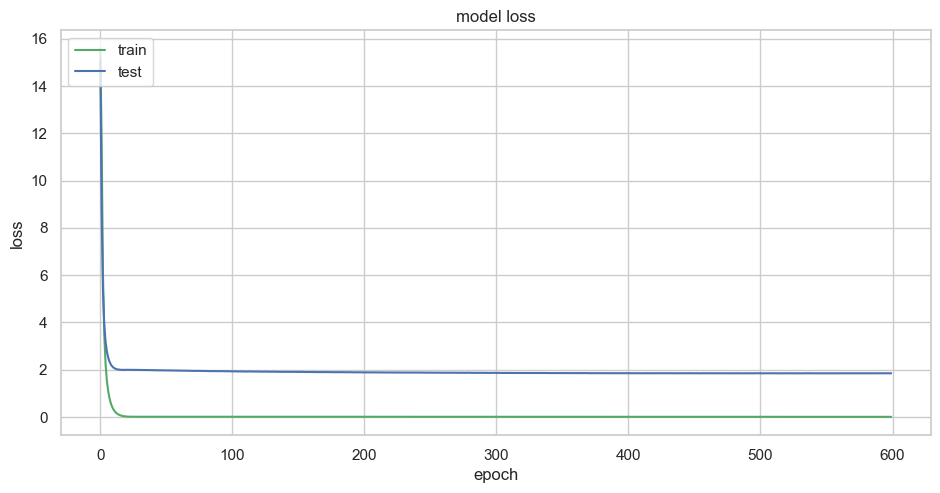

In [34]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

<a id="content5"></a>
## 5 ) Using a Neural Network

#### Now let us focus on the other main thing!!! Using a NN to matrix factorization.

1) Note that this way is not much different from the previous approach.

2) The main difference is that we have used Fully Connected layers as well as the Dropout layers and the BatchNormalization layers.

3) The number of units and the number of layers etc.. are the hyperparametrs here as in a traditional neural network.



## 5.1 ) Creating the Embeddings

####  Note that I have used 50 latent factors as that seems to give reasonable performance. Furhter tuning and careful optimization can give even better results.

In [35]:
n_latent_factors=50
n_movies=len(df['movieId'].unique())
n_users=len(df['userId'].unique())

In [36]:
user_input=Input(shape=(1,),name='user_input',dtype='int64')
user_embedding=Embedding(n_users,n_latent_factors,name='user_embedding')(user_input)
user_vec=Flatten(name='FlattenUsers')(user_embedding)
user_vec=Dropout(0.40)(user_vec)

In [37]:
movie_input=Input(shape=(1,),name='movie_input',dtype='int64')
movie_embedding=Embedding(n_movies,n_latent_factors,name='movie_embedding')(movie_input)
movie_vec=Flatten(name='FlattenMovies')(movie_embedding)
movie_vec=Dropout(0.40)(movie_vec)

In [38]:
sim=keras.layers.dot([user_vec,movie_vec],name='Simalarity-Dot-Product',axes=1)

## 5.2 ) Specifying the Model architecture

In [39]:
nn_inp=Dense(96,activation='relu')(sim)
nn_inp=Dropout(0.4)(nn_inp)
# nn_inp=BatchNormalization()(nn_inp)
nn_inp=Dense(1,activation='relu')(nn_inp)
nn_model =keras.models.Model([user_input, movie_input],nn_inp)
nn_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 50)        306800      ['user_input[0][0]']             
                                                                                                  
 movie_embedding (Embedding)    (None, 1, 50)        391050      ['movie_input[0][0]']            
                                                                                            

#### Notice the summary of the model and also the architecture of the model which u can tune of course.

## 5.3 ) Compiling the Model

In [40]:
nn_model.compile(optimizer=Adam(lr=1e-3),loss='mse')

In [41]:
batch_size=128
epochs=20

## 5. 4) Fitting on Training set & Validating on Validation Set.

In [42]:
History = nn_model.fit([train.userId,train.movieId],train.rating, batch_size=batch_size,
                              epochs =epochs, validation_data = ([valid.userId,valid.movieId],valid.rating),
                              verbose = 1)

Epoch 1/20
437/437 [==============================] - 5s 8ms/step - loss: 4.1716 - val_loss: 1.0146
Epoch 2/20
437/437 [==============================] - 3s 7ms/step - loss: 1.0998 - val_loss: 0.8507
Epoch 3/20
437/437 [==============================] - 3s 7ms/step - loss: 0.8533 - val_loss: 0.7646
Epoch 4/20
437/437 [==============================] - 3s 7ms/step - loss: 0.7060 - val_loss: 0.7273
Epoch 5/20
437/437 [==============================] - 3s 7ms/step - loss: 0.6283 - val_loss: 0.6978
Epoch 6/20
437/437 [==============================] - 3s 7ms/step - loss: 0.5783 - val_loss: 0.6840
Epoch 7/20
437/437 [==============================] - 3s 7ms/step - loss: 0.5357 - val_loss: 0.6692
Epoch 8/20
437/437 [==============================] - 3s 7ms/step - loss: 0.5114 - val_loss: 0.6560
Epoch 9/20
437/437 [==============================] - 3s 7ms/step - loss: 0.4868 - val_loss: 0.6547
Epoch 10/20
437/437 [==============================] - 3s 7ms/step - loss: 0.4586 - val_loss: 0.6448

#### Note that the validation loss is close to 0.84 which is quite decent. Also note that it has decrreased from 1.26 in the case of normal Matrix Factorization to this value here.

####  Similary playing with no of latent factors,  other parameters in the model architecture can give to even better results!!!!!

## THE END!!!